In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [478]:
x_train = pd.read_csv('x_train_full.csv')
x_val = pd.read_csv('x_val_full.csv')
x_test = pd.read_csv('x_test_full.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

In [479]:
min_max_scaler = preprocessing.MinMaxScaler()

x_train = pd.DataFrame(min_max_scaler.fit_transform(x_train), index = x_train['match_api_id'], columns = x_train.columns)
x_val = pd.DataFrame(min_max_scaler.fit_transform(x_val), index = x_val['match_api_id'], columns = x_val.columns)
x_test = pd.DataFrame(min_max_scaler.fit_transform(x_test), index = x_test['match_api_id'], columns = x_test.columns)

In [480]:
label_dict = {1:0, 0:1, -1:2 }
y_train['target'] = y_train['result'].map(label_dict)
y_val['target'] =  y_val['result'].map(label_dict)
y_test['target'] =  y_test['result'].map(label_dict)

In [502]:
# Build Network
input_size = 781
hidden_sizes = [256,256,128,64]
output_size = 3

# Build a feed-forward network
LinearNN = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Tanh(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.Softmax()
                        )


In [514]:
# Hyperparameters

batch_size =  1024 #len(x_train)
epochs = 50
learning_rate = 0.00001
loss = 0
losses = []
counter = 0

dataset = TensorDataset( Tensor(x_train.values), torch.Tensor(y_train['target']) )
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

optimizer = torch.optim.RMSprop(LinearNN.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10 , gamma = 0.1)
mse = torch.nn.MSELoss()
cross = nn.CrossEntropyLoss()

Loss after iteration 0: 0.9861227869987488
Loss after iteration 500: 1.0066274404525757
Elapsed time: 42.99498915672302 s
0.9862755537033081


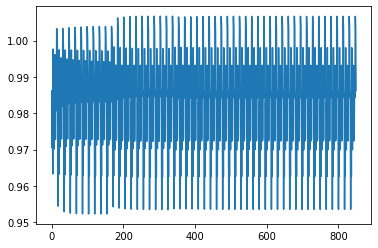

In [515]:
#Train Model

t = time.time()
for epoch in range(epochs):
    for x, y in iter(train_loader):
        LinearNN.train()
        LinearNN.zero_grad()
        
        y_pred = LinearNN(x)
        loss = cross(y_pred, y.long())
        
        if counter % 500 ==0:
            print('Loss after iteration {}: {}'.format(counter, loss.item()))
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        counter+=1 
    counter+=1
    scheduler.step()
time.time()-t        
        
        
print('Elapsed time: {} s'.format(time.time()-t))    
print(loss.item())  
plt.plot(range(len(losses)), losses)
plt.show()

In [517]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_val.values))
    
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
sklearn.metrics.accuracy_score(y_val_pred, y_val['result'])

0.5164533820840951

In [518]:
y_val_pred.value_counts()

 1    744
-1    331
 0     19
dtype: int64

In [129]:
predictions = []
actuals = []
split_index = len(data_train)
predictions_auto = []
seq_len = 50
lstm_model.eval()

plot_data = data_train + data_val
for pair in plot_data:
    
    with torch.no_grad():
        x = pair[0]
        actuals.append(pair[1][0].item())
        y_pred, h = lstm_model(x.view(seq_len,-1,6))
        predictions.append(y_pred[:,0].item())
        
last_seq = data_train[-1][0].view(seq_len,-1,6)

for i in range(len(data_val)):
    
    with torch.no_grad():
        y_pred, _ = lstm_model(last_seq)
        predictions_auto.append(y_pred[:,0].item())
        last_seq = torch.cat([last_seq,y_pred.view(1,1,6)])
        last_seq = last_seq[1:,:,:]

        


plt.plot(range(len(predictions)), predictions)
plt.plot(range(len(actuals)), actuals)
#plt.plot(range(len(data_train)+1, len(data_train+data_val)+1), predictions_auto)


plt.axvline(x =split_index, linewidth=1, color='r')
plt.show()

print('Test Set Error: {}'.format(sklearn.metrics.mean_squared_error(predictions[:split_index], actuals[:split_index])))
print('Validation Set Error: {}'.format(sklearn.metrics.mean_squared_error(predictions[split_index:], actuals[split_index:])))

NameError: name 'data_train' is not defined